# Facebook Scraping & Analytics

## Libraries

In [29]:
try:
    import urllib.request as urllib2
except ImportError:
    import urllib2   
import json
import datetime
import csv
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')
%matplotlib inline 

## Token

In [2]:
app_id = "XXX"
app_secret = "XXX" # DO NOT SHARE WITH ANYONE!

access_token = app_id + "|" + app_secret

## Scraping functions
Scraping script inspired by Max Woolf work on http://minimaxir.com/

In [5]:
 def request_until_succeed(url):
    req = urllib2.Request(url)
    success = False
    while success is False:
        try: 
            response = urllib2.urlopen(req)
            if response.getcode() == 200:
                success = True
        except Exception as e:
            print (e)
            time.sleep(5)
            print ("Error for URL %s: %s" % (url, datetime.datetime.now()))
    return response.read().decode('utf8')


def Facebook_page(page_id, access_token, num_statuses):
    # construct the URL string
    base = "https://graph.facebook.com/v2.5"
    node = "/" + page_id + "/feed" 
    parameters = "/?fields=message,link,created_time,type,name,id,full_picture,likes.limit(1).summary(true),comments.limit(1).summary(true),shares&limit=%s&access_token=%s"% (num_statuses, access_token)
    url = base + node + parameters
    # retrieve data
    data = json.loads(request_until_succeed(url))
    return data



def process_status(raw_status):
    status = {}

    status['id'] = raw_status['id']
    status['message'] = '' if 'message' not in raw_status.keys() else raw_status['message']
    status['name'] = '' if 'name' not in raw_status.keys() else raw_status['name']
    status['type'] = raw_status['type']
    status['link'] = '' if 'link' not in raw_status.keys() else raw_status['link']
    status['picture'] = '' if 'full_picture' not in raw_status.keys() else raw_status['full_picture']
    
    time = datetime.datetime.strptime(raw_status['created_time'],'%Y-%m-%dT%H:%M:%S+0000')
    time = time + datetime.timedelta(hours=-5) # EST
    status['time'] = time.strftime('%Y-%m-%d %H:%M:%S') # best time format for spreadsheet programs
    
    status['likes'] = 0 if 'likes' not in raw_status.keys() else raw_status['likes']['summary']['total_count']
    status['comments'] = 0 if 'comments' not in raw_status.keys() else raw_status['comments']['summary']['total_count']
    status['shares'] = 0 if 'shares' not in raw_status.keys() else raw_status['shares']['count']
    
    return status  



def Facebook_page_full(page_id,token = access_token):
    has_next_page = True
    num_processed = 0
    scrape_starttime = datetime.datetime.now()
    print ("Scraping %s Facebook Page: %s\n" % (page_id, scrape_starttime))
    all_statuses = []
    statuses = Facebook_page(page_id,access_token,100)

    while has_next_page:
        for status in statuses['data']:
            all_statuses.append(process_status(status)) #on coupe pour ne pas avoir les deux premières entrées
            num_processed += 1
            if num_processed % 100 == 0:
                #has_next_page = False
                print ("%s Statuses Processed: %s" % (num_processed, datetime.datetime.now()))
                    
        if 'paging' in statuses.keys():
                statuses = json.loads(request_until_succeed(statuses['paging']['next']))
        else:
            has_next_page = False
                
        
    print ("\nDone!\n%s Statuses Processed in %s" % (num_processed, datetime.datetime.now() - scrape_starttime))
    return page_id,all_statuses

#### Scrape a page feed and store the datas in a json

In [6]:
d = Facebook_page_full("perusshoes")

Scraping perusshoes Facebook Page: 2016-03-08 21:37:02.588886

100 Statuses Processed: 2016-03-08 21:37:05.055726

Done!
126 Statuses Processed in 0:00:03.900379


## Analytics

In [9]:
datas = d[1]
datas[0]

{'comments': 22,
 'id': '915544628469174_1181242285232739',
 'likes': 808,
 'link': 'https://www.facebook.com/PerusShoes/photos/a.916193141737656.1073741828.915544628469174/1181242285232739/?type=3',
 'message': 'Nous étions tranquillement en train de travailler quand soudain... nous avons réalisé que nous étions 30 000 SUR NOTRE PAGE ! Merci infiniment pour vos soutiens 🙈',
 'name': 'Timeline Photos',
 'picture': 'https://scontent.xx.fbcdn.net/hphotos-xpt1/v/t1.0-9/s720x720/12799137_1181242285232739_2761484043775317086_n.jpg?oh=955081c8d5bdb35373dd6544c28aaa4f&oe=575B1536',
 'shares': 14,
 'time': '2016-03-02 09:55:24',
 'type': 'photo'}

In [14]:
def sort_by_stat(datas,type_stat):
    '''Return the posts sorted by maximum of a statistics:*
    - "likes"
    - "comments"
    - "shares"
    '''
    return sorted(datas,key = lambda t:t[type_stat],reverse = True)

In [15]:
sort_by_stat(datas,"likes")[0]

{'comments': 131,
 'id': '915544628469174_955740467782923',
 'likes': 2193,
 'link': 'https://www.facebook.com/PerusShoes/photos/a.916193141737656.1073741828.915544628469174/955740111116292/?type=3',
 'message': "☰ AIDEZ NOUS A BATTRE LE RECORD ! ☰ Voir ci-dessous pour gagner des paires ! Après notre roadtrip en Amérique Latine, avec deux amis nous avons lancé Perús, une marque de sneakers fabriquées à la main par des artisans dans le Sud du Pérou. Chaque paire achetée permet de financer un jour d’école pour un enfant de la banlieue pauvre de Cusco. Les préventes aux prix de lancement sur ulule se terminent dans 7 jours seulement ! http://ulule.com/perus-shoes/\n___________\n\n☰ Gagnez des paires supplémentaires et battons le record d'ulule ! ☰\nNous souhaitons remercier nos plus fidèles soutiens, ceux sans qui Perús n'aurait pu se lancer... nos CONTRIBUTEURS ! Ainsi nous vous permettons de gagner des paires supplémentaires en participant à ce concours qui va dans le même temps nous ai

In [ ]:
def top_posts(datas,type_stat,n):
    """Show the n posts which have outperformed the others by likes, comments or shares"""
    result = []
    posts = sort_by_stat(datas,type_stat)[:n]
    for post in posts:
        result += [[post['picture'],post['link'],post['likes'],post['comments'],post['shares']]]
    return result

In [ ]:
def page_monthly_stats(datas):
    stats = {}
    for status in datas:
        month = status['time'][:7]
        if month in stats:
            stats[month]['likes'] += status['likes']
            stats[month]['comments'] += status['comments']
            stats[month]['shares'] += status['shares']
            stats[month]['number'] += 1
        else:
            stats[month] = {}
            stats[month]['likes'] = status['likes']
            stats[month]['comments'] = status['comments']
            stats[month]['shares'] = status['shares']
            stats[month]['number'] = 1
    for month in stats:
        stats[month]['average_likes']=stats[month]['likes']/stats[month]['number']
        stats[month]['average_comments']=stats[month]['comments']/stats[month]['number']
        stats[month]['average_shares']=stats[month]['shares']/stats[month]['number']
    return sorted(stats.items())

def get_stat(all_stats,stat):
    return [[x[0],x[1][stat]] for x in all_stats]

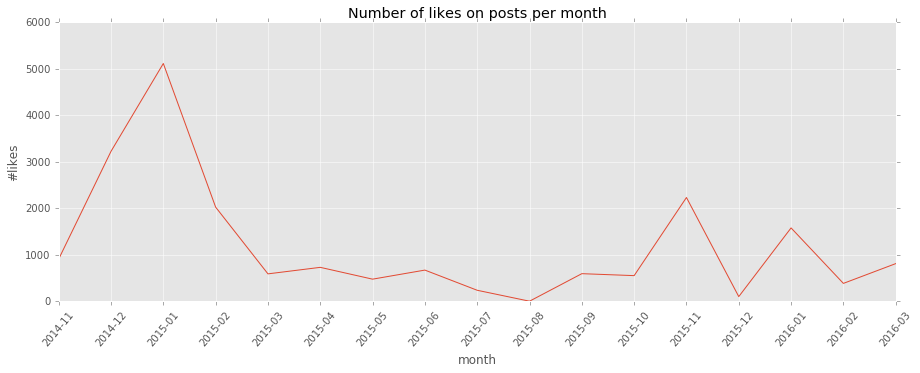

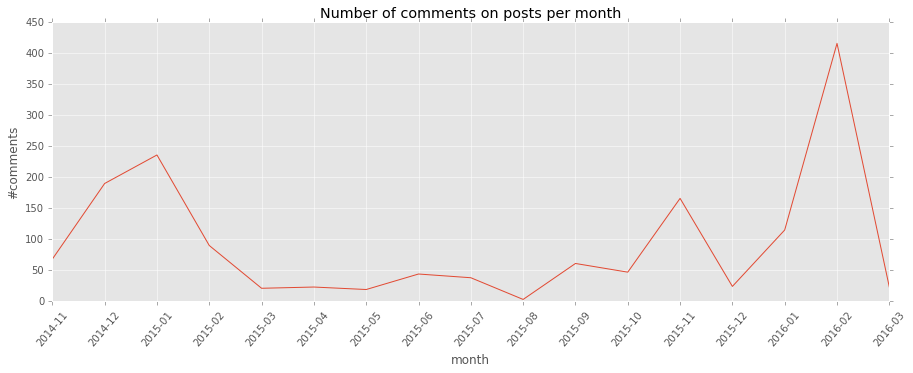

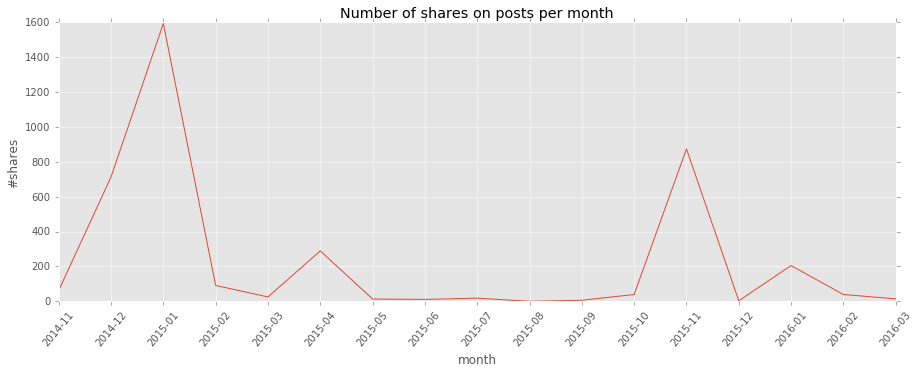

In [30]:
def data_plotting(datas,xlabel,ylabel,title,nticks):
    '''Function to plot from a DataFrame with the counts on a column'''
    z = [x[0] for x in datas]
    y = [x[1] for x in datas]
    a = range(len(datas))
    xticks = [x for x in a if x%nticks == 0]
    xlabels = [z[i] for i in xticks]
    plt.figure(figsize=(15,5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(xticks,xlabels,rotation='50')
    plt.plot(y)
    plt.title(title)
    plt.show()

for stat in ["likes","comments","shares"]:
    data_plot = get_stat(page_monthly_stats(datas),stat)
    data_plotting(data_plot,"month","#" + stat,"Number of {0} on posts per month".format(stat),1)

## Export results

In [35]:
def csv_generator(title,table,folder):
    '''To create a csv in a folder'''
    liste = [','.join([str(y) for y in x]) for x in table]
    if not os.path.exists(folder):
        os.makedirs(folder)
    with open(folder+'/'+title + ".csv", 'w') as file:
        w = csv.writer(file)
        for item in liste:
            w.writerow(item.split(','))
            
            
def top_posts_html(stat,datas,folder,page_id,n_posts = 10):
    '''Create a html file with the list of top posts'''
    title = page_id+'_top_posts_'+stat
    if not os.path.exists(folder):
        os.makedirs(folder)
    with open(folder+'/'+title + ".html", 'w') as file:
        head = """<html>
        <head></head>
        <body>
        <h1>{0}</h1>
        """.format(page_id + ' - Top posts by ' + stat)
        end = """</body></html>"""
        body = ""
        if stat == 'likes':
            posts = top_posts(datas,'likes',n_posts)
            posts = [[x[0],x[1],x[2]] for x in posts]
        elif stat == 'comments':
            posts = top_posts(datas,'comments',n_posts)
            posts = [[x[0],x[1],x[3]] for x in posts]
        elif stat == 'shares':
            posts = top_posts(datas,'shares',n_posts)
            posts = [[x[0],x[1],x[4]] for x in posts]
        for i,post in enumerate(posts):
            body+= """<h2>n°{0} - {1} : {2}</h2>
                      <a href = {3}>Link to post</a></br><img src={4} />""".format(i,stat,post[2],post[1],post[0])
        message = head + body + end
        file.write(message)
        file.close()
        
        
def log_generator(datas):
    '''Generate files with the results of the analysis'''
    page_id = datas[0]
    all_datas = datas[1]
    h = [['month','number','likes','comments','shares']]
    monthly_stats = h+[[x[0],x[1]['number'],x[1]['likes'],x[1]['comments'],x[1]['shares']] for x in page_monthly_stats(all_datas)]
    csv_generator(page_id+"_monthly_stats",monthly_stats,'log/'+page_id)
    top_posts_html('likes',all_datas,'log/'+page_id,page_id)
    top_posts_html('comments',all_datas,'log/'+page_id,page_id)
    top_posts_html('shares',all_datas,'log/'+page_id,page_id)

In [36]:
log_generator(d)

## Language Analytics

In [38]:
import nltk as nlp

stop_characters_punctuation = ["’s","\'",".",";",",",":","?","!","'","\"","(",")","&","”","“","‘","’"," ","<",">","►",":)"
                               ,"☰","-","/","://","http","www","a","les","ly","com","co","bit","...","si","cette"]

stop_words_english_1 = [""," ","it","no","at","had","into","too","him","went","with","then","how","from"
                        ,"out","in","were","that","all","but","until","and","all","them","no","it","if","not"
                        ,"or","us","in","to","on","of","are","her","his","our","your","for","is","it","i","you"
                        ,"he","she","we","have","has","they","a","the","1","2","3","4","5","6","7","8","9","and"
                        ,"his","was","when","what","who"]



def language_detection(texte):
    '''Detect a language using the number of stopwords in the text'''
    ratios = {}
    tokens = nlp.wordpunct_tokenize(texte)
    words = [word.lower() for word in tokens]
    for language in nlp.corpus.stopwords.fileids():
        stopwords_set = set(nlp.corpus.stopwords.words(language))
        words_set = set(words)
        common_elements = words_set.intersection(stopwords_set)
        ratios[language] = len(common_elements)
    return max(ratios,key=ratios.get)

In [41]:
print(language_detection("hey my name is theo, this is a test to find the language"))
print(language_detection("salut, je m'appelle theo, c'est un test pour trouver la langue"))
print(language_detection("oi, eu sou theo, é um teste para encontrar uma linguagem"))

english
french
portuguese


In [43]:
def normalize_word(word,stop_characters = stop_characters_punctuation):
    '''Prend un mot en entrée en renvoie ce mot normalisé
        c'est à dire:
        - sans les caractères spéciaux définis au préalable
        - tout en minuscule
    '''
    for item in stop_characters:
        word = word.replace(item,"") 
    word = word.lower() 
    return word



def is_not_stop_word(word,stop_words = stop_words_english_1):
    '''Le mot est-il un stop word ?
        - Soit dans la bibliothèque définie
        - Soit un mot trop court
    '''
    if len(word) < 3 or word in stop_words:
        return False
    else:
        return True


stemmer = nlp.stem.porter.PorterStemmer()


def normalize_text(text,stemming = False,stop_words = stop_words_english_1):
    '''Prend un texte dans une string et renvoie une liste de tous les mots normalisés'''
    text = text.replace('\n'," ")
    normalized_list = [normalize_word(word) for word in text.split(" ")]
    normalized_list = [word for word in normalized_list if is_not_stop_word(word,stop_words)]
    if stemming:
        normalized_list = [stemmer.stem(x) for x in normalized_list]
    return normalized_list

def normalize_text_advanced(text):
    text = text.replace('\n',' ')
    language = language_detection(text)
    stop_words = set(nlp.corpus.stopwords.words(language))
    stop_characters = set(stop_characters_punctuation)
    normalized_list = set([word.lower() for word in nlp.wordpunct_tokenize(text)])
    normalized_list = normalized_list.difference(stop_words)
    normalized_list = normalized_list.difference(stop_characters)
    return normalized_list


def language_analysis(datas):
    words_performance = {}
    for status in datas:
        words = status['message']
        words = normalize_text_advanced(words)
        for word in words:
            if word in words_performance:
                words_performance[word]['likes'] += status['likes']
                words_performance[word]['comments'] += status['comments']
                words_performance[word]['shares'] += status['shares']
                words_performance[word]['number'] += 1
            else:
                words_performance[word] = {}
                words_performance[word]['likes'] = status['likes']
                words_performance[word]['comments'] = status['comments']
                words_performance[word]['shares'] = status['shares']
                words_performance[word]['number'] = 1
    #print(words_performance)
    for word in words_performance:
        words_performance[word]['average_likes'] = words_performance[word]['likes']/words_performance[word]['number']
        words_performance[word]['average_comments'] = words_performance[word]['comments']/words_performance[word]['number']
        words_performance[word]['average_shares'] = words_performance[word]['shares']/words_performance[word]['number']
    return words_performance


def top_words(all_words,stat,n):
    words = sorted(all_words.items(),key = lambda t:t[1][stat],reverse = True)[:n]
    return [[x[0],x[1][stat]] for x in words]

In [46]:
l = language_analysis(datas)
top_words(l,"number",10)

[['perús', 48],
 ['perus', 32],
 ['merci', 20],
 ['sneakers', 20],
 ['paire', 16],
 ['plus', 15],
 ['shoes', 15],
 ['paris', 13],
 ['projet', 11],
 ['first', 10]]